Provided Helper Code for loading data and plotting (provided by Dr. Frank):

In [207]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from sklearn.decomposition  import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

with open('data/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    print(data.shape)
    Xtraindata = np.transpose(data.reshape((size, nrows*ncols)))

with open('data/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytrainlabels = data.reshape((size,)) # (Optional)

with open('data/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

with open('data/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    ytestlabels = data.reshape((size,)) # (Optional)
        

    
traindata_imgs =  np.transpose(Xtraindata).reshape((60000,28,28))       # 6000 28x28 images
print(Xtraindata.shape)
print(ytrainlabels.shape)
print(Xtestdata.shape)
print(ytestlabels.shape)

(47040000,)
(784, 60000)
(60000,)
(784, 10000)
(10000,)


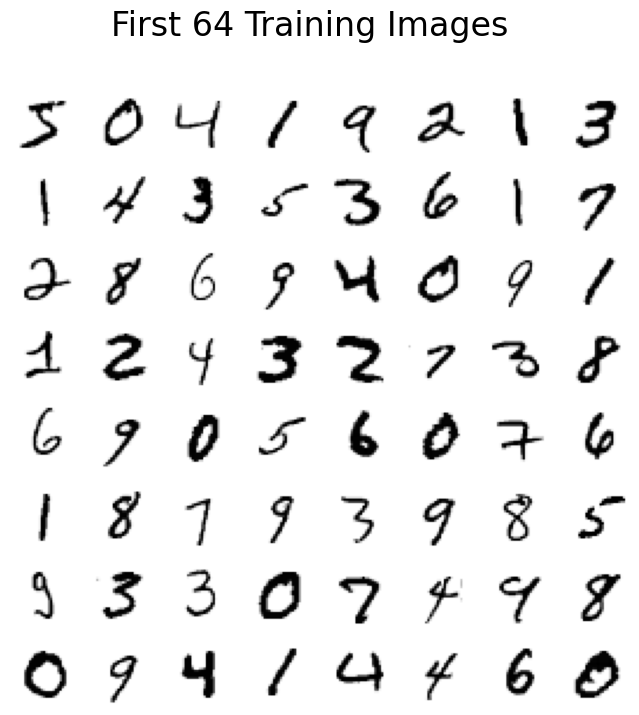

In [208]:
def plot_digits(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[:,(N)*i+j].reshape((28, 28)), cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_digits(Xtraindata, 8, "First 64 Training Images" )
plt.savefig("AMATH482_HW3_fig1.png")


My Code:

Task I:

In [209]:
X_train = Xtraindata.T
X_test = Xtestdata.T

print(X_train.shape)    # 60000 x 784 (784 data points, i.e. pixels, per image)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [210]:
# get first 16 PCA modes -
pca = PCA(16)
pca.fit(X_train)
modes = pca.components_  # gives the PCs i.e. modes

print(modes.shape)

(16, 784)


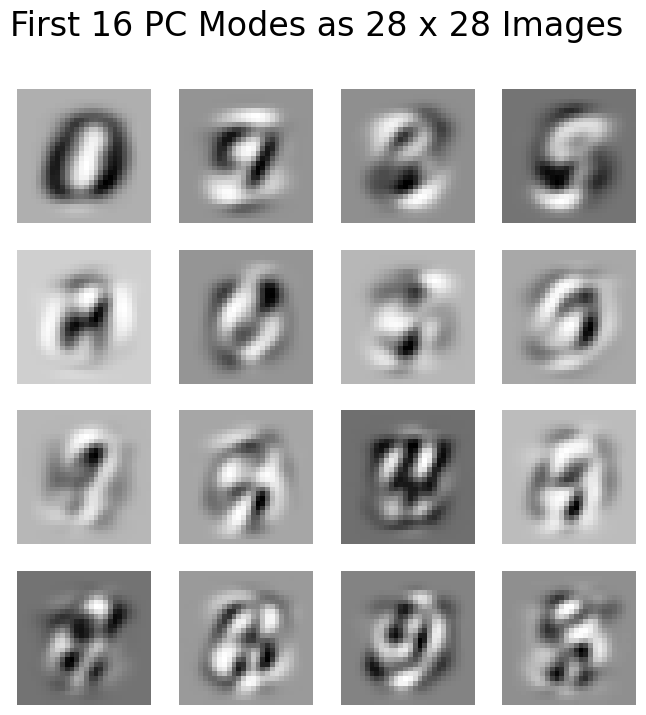

In [211]:
plot_digits(modes.T, 4, "First 16 PC Modes as 28 x 28 Images" )
plt.savefig("AMATH482_HW3_fig2.png")

Task II:

In [212]:
pca = PCA()
pca.fit_transform(X_train)
ratios = pca.explained_variance_ratio_

E_cumulative = 0

k = 0

for j in range(0, 784):
    E_cumulative += ratios[j]
    if E_cumulative >= 0.85:
        k = j + 1
        break

In [213]:
print(k)

59


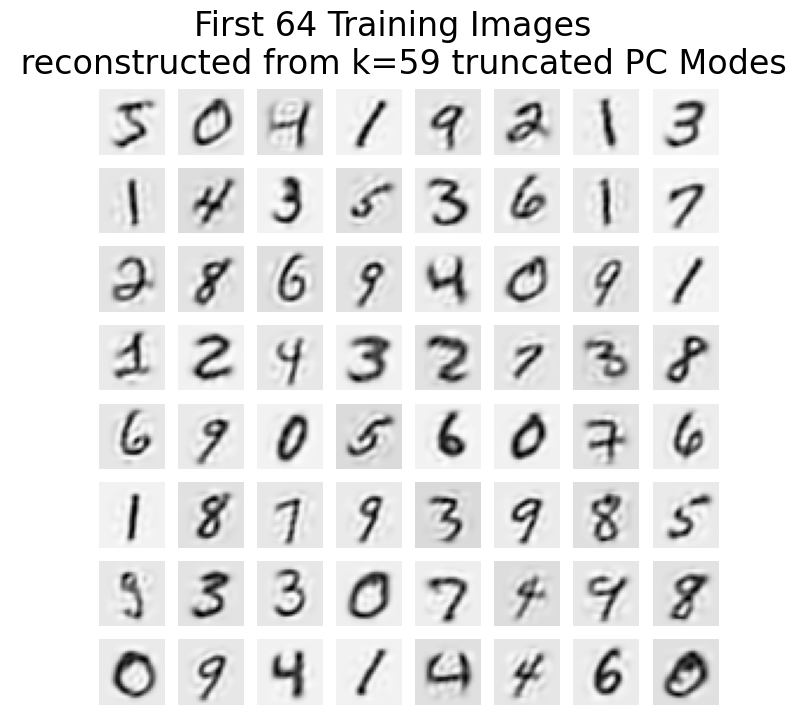

In [214]:
pca_k = PCA(k)
pca_k.fit(X_train)
Xtrain_k = pca_k.transform(X_train)
Xtest_k = pca_k.transform(X_test)
Xtrain_k_inv = pca_k.inverse_transform(Xtrain_k)

plot_digits(Xtrain_k_inv.T, 8, "First 64 Training Images \n reconstructed from k=59 truncated PC Modes" )
plt.savefig("AMATH482_HW3_fig3.png")

Task III:

In [215]:
def target_subset(target):
    indeces_train = [i for i, val in enumerate(ytrainlabels) if val in target]
    Xsubtrain = Xtrain_k[indeces_train, :]
    ysubtrain = ytrainlabels[indeces_train]

    indeces_test = [i for i, val in enumerate(ytestlabels) if val in target]
    Xsubtest = Xtest_k[indeces_test, :]
    ysubtest = ytestlabels[indeces_test]

    return Xsubtrain, ysubtrain, Xsubtest, ysubtest

Task IV:

In [216]:
target = [1, 8]

Xsubtrain, ysubtrain, Xsubtest, ysubtest = target_subset(target)

RidgeCL = RidgeClassifier()   # instantiate Ridge Classifier 

alpha_vals = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14, 1e15]

alpha_grid = {'alpha': alpha_vals}

grid_search = GridSearchCV(estimator=RidgeCL, param_grid=alpha_grid, cv = 5)

grid_search.fit(Xsubtrain, ysubtrain)

alpha_opt_1and8 = grid_search.best_params_['alpha']

cv_results = grid_search.cv_results_

RidgeCL_opt = grid_search.best_estimator_

train_acc_1and8 = RidgeCL_opt.score(Xsubtrain, ysubtrain)
test_acc_1and8 = RidgeCL_opt.score(Xsubtest, ysubtest)

print('Optimal alpha (regularization parameter) from Cross Validation:', alpha_opt_1and8)
print('Training accuracy:', train_acc_1and8)
print('Testing accuracy:', test_acc_1and8)

Optimal alpha (regularization parameter) from Cross Validation: 100000000.0
Training accuracy: 0.9654569999205908
Testing accuracy: 0.979611190137506


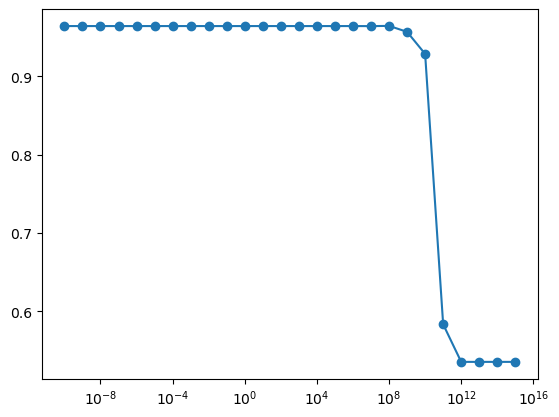

In [217]:
plt.plot(alpha_vals, cv_results['mean_test_score'])
plt.scatter(alpha_vals, cv_results['mean_test_score'])
plt.xscale("log")

In [218]:
scores_1and8 = cv_results['mean_test_score']
print(cv_results['mean_test_score'])
print(cv_results['std_test_score'])

[0.96426614 0.96426614 0.96426614 0.96426614 0.96426614 0.96426614
 0.96426614 0.96426614 0.96426614 0.96426614 0.96426614 0.96426614
 0.96426614 0.96426614 0.96426614 0.96426614 0.96426614 0.96418678
 0.96450449 0.95688094 0.92869096 0.5833392  0.53537679 0.53537679
 0.53537679 0.53537679]
[0.00266563 0.00266563 0.00266563 0.00266563 0.00266563 0.00266563
 0.00266563 0.00266563 0.00266563 0.00266563 0.00266563 0.00266563
 0.00266563 0.00266563 0.00266563 0.00266563 0.00280394 0.00298217
 0.00339831 0.00286752 0.00460062 0.00547558 0.00014719 0.00014719
 0.00014719 0.00014719]


Task V:

In [219]:
# Repeat task IV with new target sets:

target2 = [3, 8]

Xsubtrain, ysubtrain, Xsubtest, ysubtest = target_subset(target2)

RidgeCL = RidgeClassifier()   # instantiate Ridge Classifier 

alpha_grid = {'alpha': alpha_vals}

grid_search = GridSearchCV(estimator=RidgeCL, param_grid=alpha_grid, cv = 5)

grid_search.fit(Xsubtrain, ysubtrain)

alpha_opt_3and8 = grid_search.best_params_['alpha']

cv_results = grid_search.cv_results_

RidgeCL_opt = grid_search.best_estimator_

train_acc_3and8 = RidgeCL_opt.score(Xsubtrain, ysubtrain)
test_acc_3and8 = RidgeCL_opt.score(Xsubtest, ysubtest)

print('Optimal alpha (regularization parameter) from Cross Validation:', alpha_opt_3and8)
print('Training accuracy:', train_acc_3and8)
print('Testing accuracy:', test_acc_3and8)

Optimal alpha (regularization parameter) from Cross Validation: 100000.0
Training accuracy: 0.9601902854281422
Testing accuracy: 0.9637096774193549


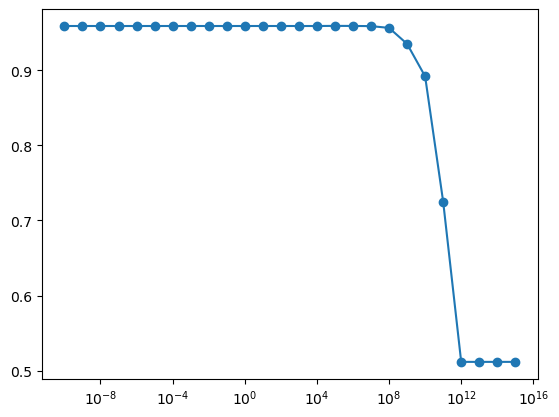

In [220]:
plt.plot(alpha_vals, cv_results['mean_test_score'])
plt.scatter(alpha_vals, cv_results['mean_test_score'])
plt.xscale("log")

In [221]:
scores_3and8 = cv_results['mean_test_score']
print(cv_results['mean_test_score'])
print(cv_results['std_test_score'])

[0.95868866 0.95868866 0.95868866 0.95868866 0.95868866 0.95868866
 0.95868866 0.95868866 0.95868866 0.95868866 0.95868866 0.95868866
 0.95868866 0.95868866 0.95868866 0.95885557 0.95877213 0.95852185
 0.9561848  0.93490298 0.89167159 0.725002   0.51168419 0.51168419
 0.51168419 0.51168419]
[0.00620834 0.00620834 0.00620834 0.00620834 0.00620834 0.00620834
 0.00620834 0.00620834 0.00620834 0.00620834 0.00620834 0.00620834
 0.00620834 0.00620834 0.00620834 0.00625093 0.00653307 0.00682037
 0.00620895 0.00782477 0.00987685 0.01163608 0.00013195 0.00013195
 0.00013195 0.00013195]


In [222]:
target3 = [2, 7]

Xsubtrain, ysubtrain, Xsubtest, ysubtest = target_subset(target3)

RidgeCL = RidgeClassifier()   # instantiate Ridge Classifier 

alpha_grid = {'alpha': alpha_vals}

grid_search = GridSearchCV(estimator=RidgeCL, param_grid=alpha_grid, cv = 5)

grid_search.fit(Xsubtrain, ysubtrain)

alpha_opt_2and7 = grid_search.best_params_['alpha']

cv_results = grid_search.cv_results_

RidgeCL_opt = grid_search.best_estimator_

train_acc_2and7 = RidgeCL_opt.score(Xsubtrain, ysubtrain)
test_acc_2and7 = RidgeCL_opt.score(Xsubtest, ysubtest)

print('Optimal alpha (regularization parameter) from Cross Validation:', alpha_opt_2and7)
print('Training accuracy:', train_acc_2and7)
print('Testing accuracy:', test_acc_2and7)

Optimal alpha (regularization parameter) from Cross Validation: 100000.0
Training accuracy: 0.9798740080176715
Testing accuracy: 0.974757281553398


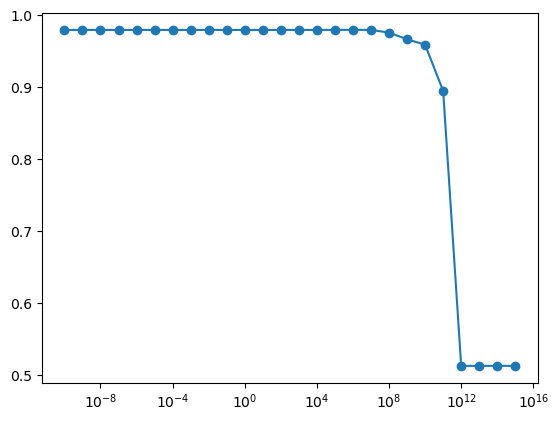

In [223]:
plt.plot(alpha_vals, cv_results['mean_test_score'])
plt.scatter(alpha_vals, cv_results['mean_test_score'])
plt.xscale("log")

In [224]:
scores_2and7 = cv_results['mean_test_score']
print(cv_results['mean_test_score'])
print(cv_results['std_test_score'])

[0.97962866 0.97962866 0.97962866 0.97962866 0.97962866 0.97962866
 0.97962866 0.97962866 0.97962866 0.97962866 0.97962866 0.97962866
 0.97962866 0.97962866 0.97962866 0.97971049 0.97971049 0.97962855
 0.97594694 0.96662014 0.95909338 0.89479    0.51255831 0.51255831
 0.51255831 0.51255831]
[0.00188979 0.00188979 0.00188979 0.00188979 0.00188979 0.00188979
 0.00188979 0.00188979 0.00188979 0.00188979 0.00188979 0.00188979
 0.00188979 0.00188979 0.00188979 0.00182099 0.00182099 0.00220158
 0.0024738  0.00478905 0.00532754 0.00831041 0.00010273 0.00010273
 0.00010273 0.00010273]


Task VI:

In [225]:
# Use all the digits now: perform multi-class classification with Ridge Classification

RidgeCL = RidgeClassifier()   # instantiate Ridge Classifier 

alpha_grid = {'alpha': alpha_vals}

grid_search = GridSearchCV(estimator=RidgeCL, param_grid=alpha_grid, cv = 5)

grid_search.fit(Xtrain_k, ytrainlabels)

alpha_opt_alldigits = grid_search.best_params_['alpha']

cv_results = grid_search.cv_results_

RidgeCL_opt = grid_search.best_estimator_

train_acc_alldigits = RidgeCL_opt.score(Xtrain_k, ytrainlabels)
test_acc_alldigits = RidgeCL_opt.score(Xtest_k, ytestlabels)

print('Optimal alpha (regularization parameter) from Cross Validation:', alpha_opt_alldigits)
print('Training accuracy:', train_acc_alldigits)
print('Testing accuracy:', test_acc_alldigits)

Optimal alpha (regularization parameter) from Cross Validation: 1e-10
Training accuracy: 0.8451833333333333
Testing accuracy: 0.856


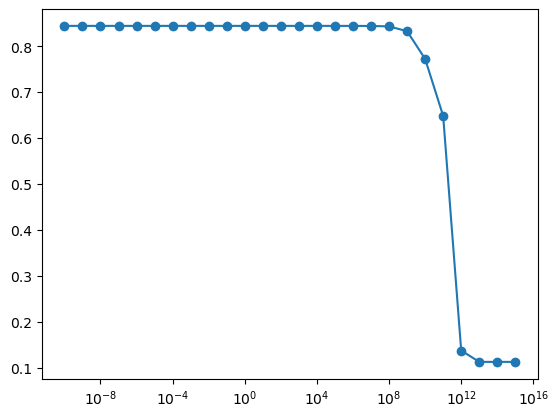

In [226]:
plt.plot(alpha_vals, cv_results['mean_test_score'])
plt.scatter(alpha_vals, cv_results['mean_test_score'])
plt.xscale("log")

In [227]:
scores_alldigits = cv_results['mean_test_score']
print(cv_results['mean_test_score'])
print(cv_results['std_test_score'])

[0.84406667 0.84406667 0.84406667 0.84406667 0.84406667 0.84406667
 0.84406667 0.84406667 0.84406667 0.84406667 0.84406667 0.84406667
 0.84406667 0.84406667 0.84406667 0.84406667 0.84401667 0.84391667
 0.84291667 0.83253333 0.77213333 0.6481     0.13711667 0.11236667
 0.11236667 0.11236667]
[9.67864201e-03 9.67864201e-03 9.67864201e-03 9.67864201e-03
 9.67864201e-03 9.67864201e-03 9.67864201e-03 9.67864201e-03
 9.67864201e-03 9.67864201e-03 9.67864201e-03 9.67864201e-03
 9.67864201e-03 9.67864201e-03 9.67864201e-03 9.67864201e-03
 9.67088988e-03 9.67255568e-03 1.00109662e-02 1.00232507e-02
 9.97936760e-03 8.87652960e-03 2.74853496e-03 4.08248290e-05
 4.08248290e-05 4.08248290e-05]


In [228]:
# Perform multi-class classification with KNN classification method:

KNN_Classifier = KNeighborsClassifier()   # instantiate Ridge Classifier

num_neighbors = [1, 2, 4, 8, 16]

k_grid = {'n_neighbors': num_neighbors}

grid_search = GridSearchCV(estimator=KNN_Classifier, param_grid=k_grid, cv = 5)

grid_search.fit(Xtrain_k, ytrainlabels)

k_opt = grid_search.best_params_['n_neighbors']

cv_results = grid_search.cv_results_

KNN_opt = grid_search.best_estimator_

train_acc_KNN = KNN_opt.score(Xtrain_k, ytrainlabels)
test_acc_KNN = KNN_opt.score(Xtest_k, ytestlabels)

print('Optimal number of neighbors (k) from Cross Validation:', k_opt)
print('Training accuracy:', train_acc_KNN)
print('Testing accuracy:', test_acc_KNN)

Optimal number of neighbors (k) from Cross Validation: 4
Training accuracy: 0.9866166666666667
Testing accuracy: 0.9745


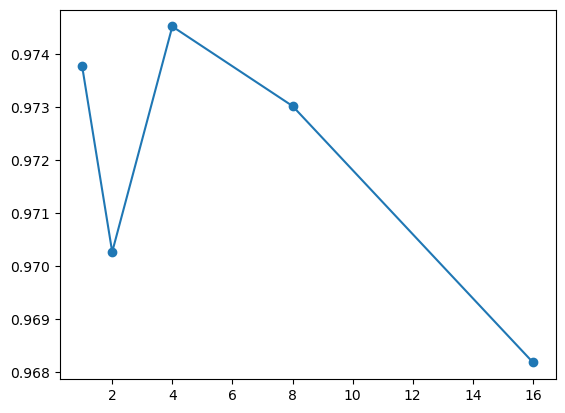

In [229]:
plt.plot(num_neighbors, cv_results['mean_test_score'])
plt.scatter(num_neighbors, cv_results['mean_test_score'])

In [230]:
scores_KNN = cv_results['mean_test_score']
print(cv_results['mean_test_score'])
print(cv_results['std_test_score'])

[0.97376667 0.97026667 0.97451667 0.97301667 0.96818333]
[0.00220693 0.00132853 0.00157003 0.00049554 0.00124209]


Task VII: Bonus

In [231]:
# Implement a naive-Bayes Classifier (Gaussian):

NB_Classifier = GaussianNB()  # Instantiate naive-bayes classifier

varsmoothing_vals = [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]

varsmoothing_grid = {'var_smoothing': varsmoothing_vals}

grid_search = GridSearchCV(estimator=NB_Classifier, param_grid=varsmoothing_grid, cv = 5)

grid_search.fit(Xtrain_k, ytrainlabels)

varsmoothing_opt = grid_search.best_params_['var_smoothing']

cv_results = grid_search.cv_results_

NB_Classifier_opt = grid_search.best_estimator_

train_acc_NB = NB_Classifier_opt.score(Xtrain_k, ytrainlabels)
test_acc_NB = NB_Classifier_opt.score(Xtest_k, ytestlabels)

print('Optimal variance smoothing value from Cross Validation:', varsmoothing_opt)
print('Training accuracy:', train_acc_NB)
print('Testing accuracy:', test_acc_NB)

Optimal variance smoothing value from Cross Validation: 0.001
Training accuracy: 0.8733
Testing accuracy: 0.8812


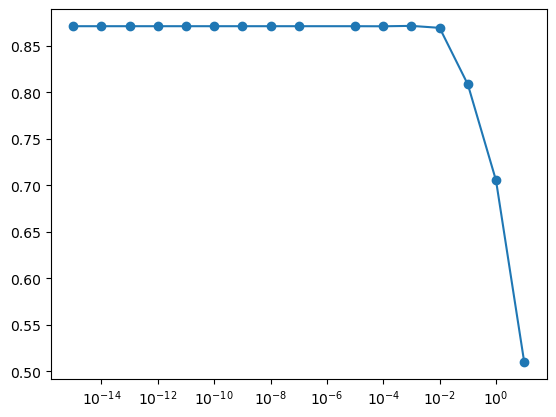

In [232]:
plt.plot(varsmoothing_vals, cv_results['mean_test_score'])
plt.scatter(varsmoothing_vals, cv_results['mean_test_score'])
plt.xscale("log")

In [233]:
scores_NB = cv_results['mean_test_score']
print(cv_results['mean_test_score'])
print(cv_results['std_test_score'])

[0.87113333 0.87113333 0.87113333 0.87113333 0.87113333 0.87113333
 0.87113333 0.87113333 0.87113333 0.87113333 0.87105    0.87148333
 0.86936667 0.8086     0.7054     0.51026667]
[0.0083391  0.0083391  0.0083391  0.0083391  0.0083391  0.0083391
 0.0083391  0.0083391  0.0083391  0.00838328 0.00849552 0.00860191
 0.00857299 0.00902072 0.01052027 0.01024185]


Plots and Figures:

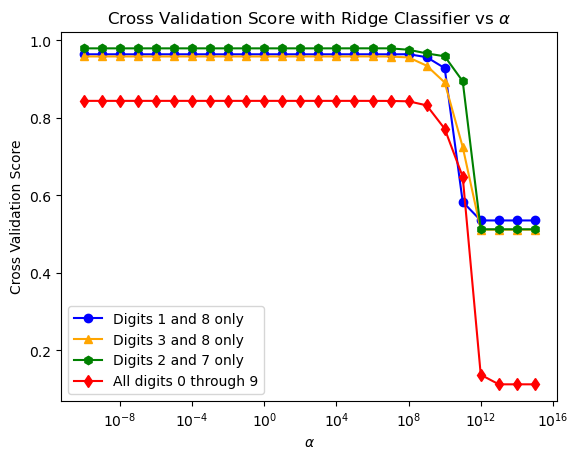

In [234]:
plt.figure(figsize=(6.4, 4.8))
plt.plot(alpha_vals, scores_1and8, label='Digits 1 and 8 only', marker = 'o', color = 'blue')
plt.plot(alpha_vals, scores_3and8, label='Digits 3 and 8 only', marker = '^', color = 'orange')
plt.plot(alpha_vals, scores_2and7, label='Digits 2 and 7 only', marker = 'h', color = 'green')
plt.plot(alpha_vals, scores_alldigits, label='All digits 0 through 9', marker = 'd', color = 'red')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Cross Validation Score')
plt.title(r'Cross Validation Score with Ridge Classifier vs $\alpha$')
plt.legend()
plt.savefig("AMATH482_HW3_fig4.png")

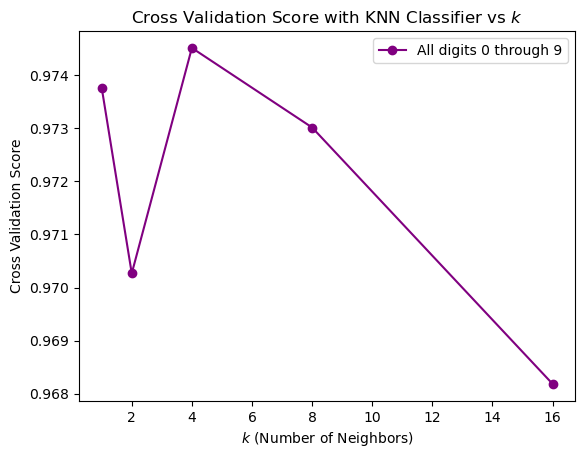

In [235]:
plt.plot(num_neighbors, scores_KNN, label='All digits 0 through 9', color='purple', marker = 'o')
plt.title(r'Cross Validation Score with KNN Classifier vs $k$')
plt.xlabel(r'$k$ (Number of Neighbors)')
plt.ylabel('Cross Validation Score')
plt.legend()
plt.savefig('AMATH482_HW3_fig5.png')

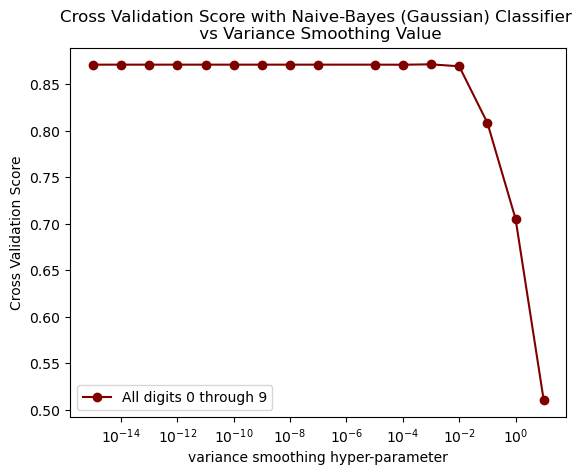

In [246]:
plt.plot(varsmoothing_vals, scores_NB, label='All digits 0 through 9', color = 'maroon', marker = 'o')
plt.xscale('log')
plt.title('Cross Validation Score with Naive-Bayes (Gaussian) Classifier \n vs Variance Smoothing Value')
plt.xlabel(r'variance smoothing hyper-parameter')
plt.ylabel('Cross Validation Score')
plt.legend()
plt.savefig('AMATH482_HW3_fig6.png')

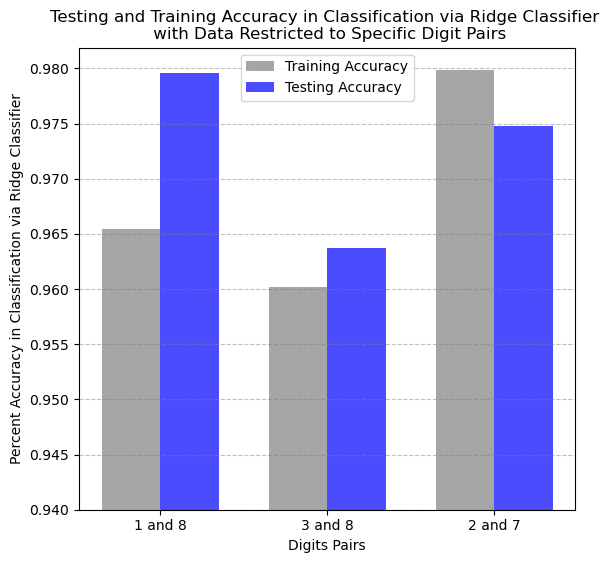

In [237]:
values = [train_acc_1and8, test_acc_1and8, train_acc_3and8, test_acc_3and8, train_acc_2and7, test_acc_2and7]
labels = ['1 and 8', '3 and 8', '2 and 7']
bar_width = 0.35
x = np.arange(3)

fig, ax = plt.subplots(figsize=(6.4, 6))

trainbar_heights = [i-0.94 for i in values[::2]]
testbar_heights = [i-0.94 for i in values[1::2]]

train_bars = ax.bar(x - bar_width/2, trainbar_heights, bar_width, color = 'grey', label = 'Training Accuracy', bottom = 0.94, alpha = 0.7)
test_bars = ax.bar(x + bar_width/2, testbar_heights, bar_width, color = 'blue', label = 'Testing Accuracy', bottom = 0.94, alpha = 0.7)

ax.set_xlabel('Digits Pairs')
ax.set_ylabel('Percent Accuracy in Classification via Ridge Classifier')
ax.set_title('Testing and Training Accuracy in Classification via Ridge Classifier \n with Data Restricted to Specific Digit Pairs')
ax.legend()

ax.set_xticks([0.0, 1.0, 2.0])
ax.set_xticklabels(labels)
ax.grid(axis='y', linestyle='--', color='gray', alpha=0.5)

plt.savefig('AMATH482_HW3_fig7.png')

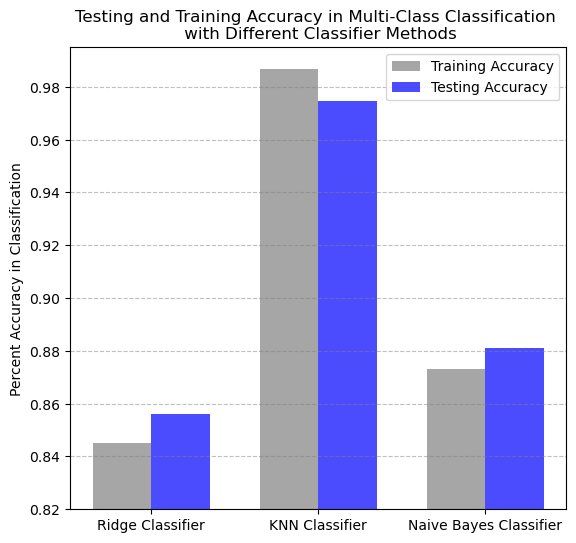

In [244]:
values = [train_acc_alldigits, test_acc_alldigits, train_acc_KNN, test_acc_KNN, train_acc_NB, test_acc_NB]
labels = ['Ridge Classifier', 'KNN Classifier', "Naive Bayes Classifier"]
bar_width = 0.35
x = np.arange(3)

fig, ax = plt.subplots(figsize=(6.4, 6))

trainbar_heights = [i-0.82 for i in values[::2]]
testbar_heights = [i-0.82 for i in values[1::2]]

train_bars = ax.bar(x - bar_width/2, trainbar_heights, bar_width, color = 'grey', label = 'Training Accuracy', bottom = 0.82, alpha = 0.7)
test_bars = ax.bar(x + bar_width/2, testbar_heights, bar_width, color = 'blue', label = 'Testing Accuracy', bottom = 0.82, alpha = 0.7)

ax.set_ylabel('Percent Accuracy in Classification')
ax.set_title('Testing and Training Accuracy in Multi-Class Classification \n with Different Classifier Methods')
ax.legend()

ax.set_xticks([0.0, 1.0, 2.0])
ax.set_xticklabels(labels)
ax.grid(axis='y', linestyle='--', color='gray', alpha=0.5)
plt.savefig('AMATH482_HW3_fig8.png')

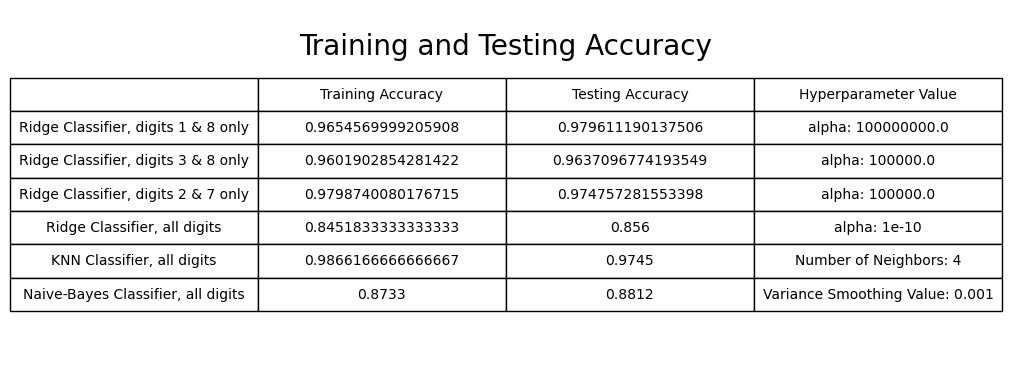

<Figure size 640x480 with 0 Axes>

In [243]:
data = [['Ridge Classifier, digits 1 & 8 only', train_acc_1and8, test_acc_1and8, "alpha: " + str(alpha_opt_1and8)],
        ['Ridge Classifier, digits 3 & 8 only', train_acc_3and8, test_acc_3and8, "alpha: " + str(alpha_opt_3and8)],
        ['Ridge Classifier, digits 2 & 7 only', train_acc_2and7, test_acc_2and7, "alpha: " + str(alpha_opt_2and7)],
        ['Ridge Classifier, all digits', train_acc_alldigits, test_acc_alldigits, "alpha: " + str(alpha_opt_alldigits)],
        ['KNN Classifier, all digits', train_acc_KNN, test_acc_KNN, "Number of Neighbors: " + str(k_opt)],
        ['Naive-Bayes Classifier, all digits', train_acc_NB, test_acc_NB, "Variance Smoothing Value: " + str(varsmoothing_opt)]
]

cols = ['', 'Training Accuracy', 'Testing Accuracy', 'Hyperparameter Value']

fig, ax = plt.subplots()
ax.axis('off')

acc_table = ax.table(cellText=data, colLabels=cols, loc='center', cellLoc = 'center')
acc_table.auto_set_font_size(False)
acc_table.set_fontsize(10)
acc_table.scale(2, 2)
ax.text(0.5, 0.9, 'Training and Testing Accuracy', ha='center', va='center', fontsize = 20)
plt.show()
plt.savefig('AMATH482_HW3_fig9.png')

Confusion Matrices for Ridge, KNN, Naive-Bayes (Code provided by Dr. Frank):

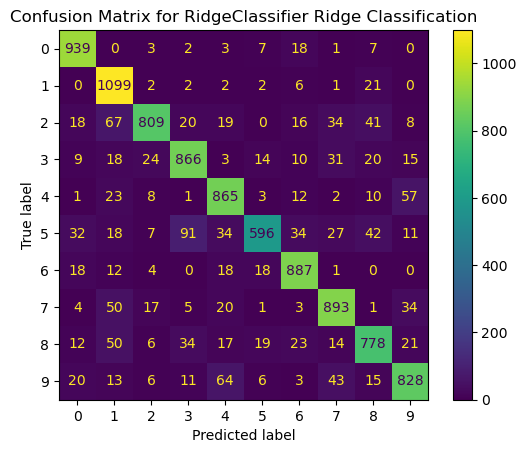

In [240]:
y_pred = RidgeCL_opt.predict(Xtest_k)

y_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(ytestlabels, y_pred, ax=ax)
ax.xaxis.set_ticklabels(y_names)
ax.yaxis.set_ticklabels(y_names)
_ = ax.set_title(f"Confusion Matrix for {RidgeCL_opt.__class__.__name__} Ridge Classification")
plt.savefig('AMATH482_HW3_fig10.png')

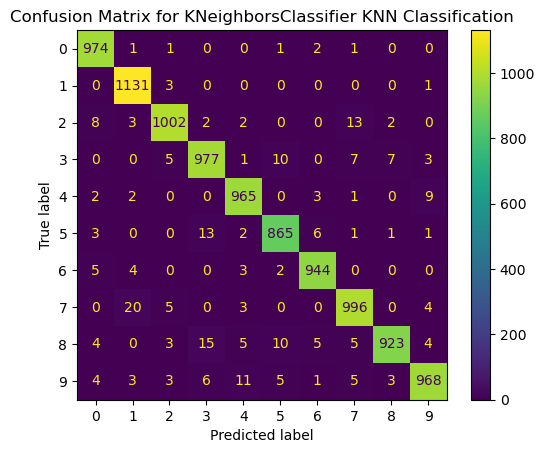

In [241]:
y_pred = KNN_opt.predict(Xtest_k)

y_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(ytestlabels, y_pred, ax=ax)
ax.xaxis.set_ticklabels(y_names)
ax.yaxis.set_ticklabels(y_names)
_ = ax.set_title(f"Confusion Matrix for {KNN_opt.__class__.__name__} KNN Classification")
plt.savefig('AMATH482_HW3_fig11.png')

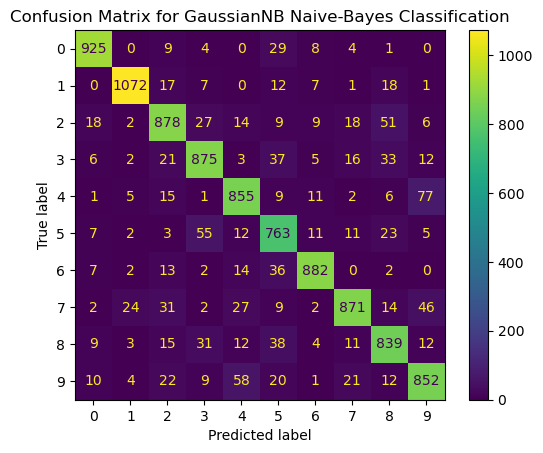

In [242]:
y_pred = NB_Classifier_opt.predict(Xtest_k)

y_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(ytestlabels, y_pred, ax=ax)
ax.xaxis.set_ticklabels(y_names)
ax.yaxis.set_ticklabels(y_names)
_ = ax.set_title(f"Confusion Matrix for {NB_Classifier_opt.__class__.__name__} Naive-Bayes Classification")
plt.savefig('AMATH482_HW3_fig12.png')